# Set for jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Env

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image

In [3]:
from modules.dataset import get_loader
from modules.utils import imsshow, imgshow
from modules.network import UNet
from modules.loss import MyBinaryCrossEntropy
from modules.solver import Lab2Solver

# Data process

In [4]:
RV = [85]
MYO = [170]
LV = [255]

train_loader = get_loader(image_root_path='./ACDC-2D-All/train/',palette=[RV,MYO,LV], batch_size=32, mode='train')
val_loader = get_loader(image_root_path='./ACDC-2D-All/val/', palette=[RV,MYO,LV], batch_size=32, mode='val')
test_loader = get_loader(image_root_path='./ACDC-2D-All/test/',palette=[RV,MYO,LV], batch_size=32, mode='test')

image count in train path :1394
image count in val path :200
image count in test path :204


torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


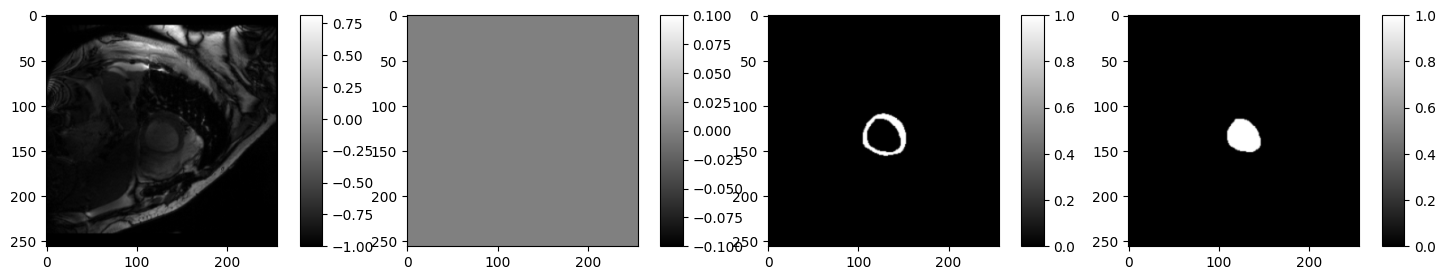

In [5]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
imsshow([image[5, 0, :, :], seg_gt[5, 0, :, :],seg_gt[5, 1, :, :],seg_gt[5, 2, :, :]], is_colorbar=True, cmap='gray', is_ticks=True)

# Networl and Solver

In [6]:
net = UNet(n_channels=1, n_classes=3, C_base=32)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = Lab2Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler,
    device="cuda:2"
)

# Train

In [13]:
solver.train(
    epochs=50, 
    data_loader=train_loader,
    val_loader=val_loader
)

  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

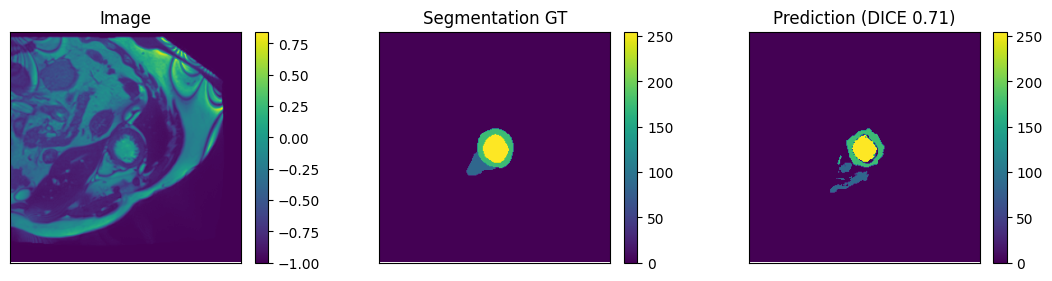

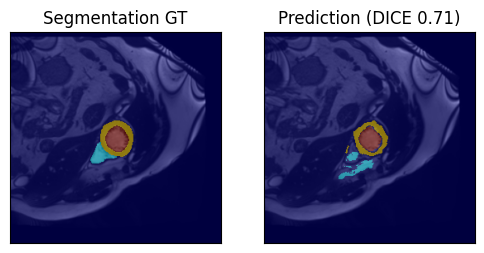

In [31]:
solver.visualize(val_loader, 20)